
<h1>User-based Collaborative Filtering using KNN</h1>

# Introduction

This Notebook is building a User-based collaborative filtering Recommendation System for Movielens (adapted from Gabriel Preda)

# Analysis preparation

In [1]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

## Read users data

In [2]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('DATA/user.csv', sep='|', names=user_columns) 
users_df.head(10)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


## Read movies data

In [3]:
genre_df = pd.read_csv('DATA/genre.csv', sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
genre_columns

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [4]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('DATA/item.csv', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')

Because we are not building now a content-based recommender, we retain only `movie_id` and `title`.

In [5]:
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(10)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


## Read ratings data

In [6]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('DATA/data.csv', sep='\t', names=ratings_columns)
ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df.head(10)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


We merge now ratings with movie data.

In [7]:
rating_movies_df = ratings_df.merge(movies_df, how="outer")

In [8]:
print(rating_movies_df.shape)
rating_movies_df.head(10)

(100000, 4)


,user_id,movie_id,rating,title
0,308,1,4,Toy Story (1995)
1,287,1,5,Toy Story (1995)
2,148,1,4,Toy Story (1995)
3,280,1,4,Toy Story (1995)
4,66,1,3,Toy Story (1995)
5,5,1,4,Toy Story (1995)
6,109,1,4,Toy Story (1995)
7,181,1,3,Toy Story (1995)
8,95,1,5,Toy Story (1995)
9,268,1,3,Toy Story (1995)


## Calculate total rating movie


We will calculate now the total rating movie. We will only consider movies with a minimum rating factor, set conveniently so that we will not take into consideration movies that were only rated by a very small number of users.

In [9]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),109
3,12 Angry Men (1957),125
4,187 (1997),41


### Merge total rating count to the movie ratings

In [10]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")
rating_movies_df.sort_values(by='user_id').head()

,user_id,movie_id,rating,title,total_rating_count
42758,1,101,2,Heavy Metal (1981),73
85666,1,50,5,Star Wars (1977),583
42857,1,190,5,Henry V (1989),124
1910,1,261,1,Air Bud (1997),43
55982,1,166,5,Manon of the Spring (Manon des sources) (1986),58


### Filter only movies with a number of ratings over a threshold

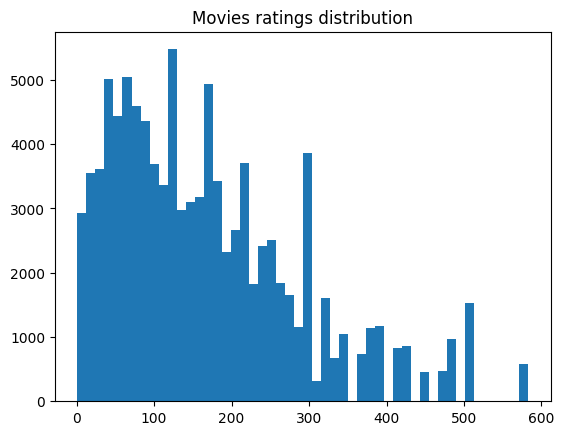

In [11]:
rating_movies_df.total_rating_count.describe()

import matplotlib.pyplot as plt
plt.hist(rating_movies_df.total_rating_count, bins=50)
plt.title("Movies ratings distribution")
plt.show()

We will only consider moview with at least 100 ratings.

In [12]:
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.sort_values(by='user_id').head()

(65008, 5)


,user_id,movie_id,rating,title,total_rating_count
99812,1,232,3,Young Guns (1988),101
69327,1,55,5,"Professional, The (1994)",149
23400,1,9,5,Dead Man Walking (1995),299
58320,1,264,2,Mimic (1997),101
84575,1,222,4,Star Trek: First Contact (1996),365


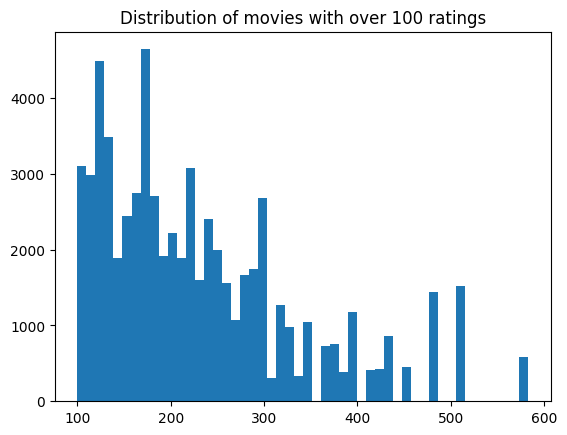

In [13]:
plt.hist(rating_popular_movies_df.total_rating_count, bins=50)
plt.title("Distribution of movies with over 100 ratings")
plt.show()

## Create pivot matrix (pivot table)

We create a sparse matrix from the original dataframe.
This will allow the following operations to be performed on a sparse matrix, i.e. faster (only non-zero values are included).

In [14]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)
user_features_matrix = csr_matrix(user_features_df) #Compressed Sparse Row matrix
user_features_df.shape

(943, 338)

In [15]:
user_features_df.head()

title,101 Dalmatians (1996),12 Angry Men (1957),2001: A Space Odyssey (1968),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),"Adventures of Priscilla, Queen of the Desert, The (1994)","African Queen, The (1951)",Air Force One (1997),Aladdin (1992),...,Welcome to the Dollhouse (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wrong Trousers, The (1993)",Young Frankenstein (1974),Young Guns (1988)
user_id,,,,,,,,,,,,,,,,,,,,,
1,2.0,5.0,4.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,...,5.0,4.0,5.0,4.0,0.0,4.0,4.0,5.0,5.0,3.0
2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,1.0,1.0,1.0,3.0,0.0,5.0,4.0,0.0


We will use NearestNeighbors class since we don´t want classification or regression, only find nearest neighbors

In [16]:
# we use cosine since the euclidean does not work well with sparse matrix
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(user_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

## Test the recommendation

Select one user.

In [17]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index+1) #since the index starts by 0 in the following queries

753


Use the model fit to get the closest movies

In [18]:
user_features_df.iloc[query_index,:]

title
101 Dalmatians (1996)                           0.0
12 Angry Men (1957)                             0.0
2001: A Space Odyssey (1968)                    0.0
Absolute Power (1997)                           0.0
Abyss, The (1989)                               0.0
                                               ... 
Willy Wonka and the Chocolate Factory (1971)    0.0
Wizard of Oz, The (1939)                        0.0
Wrong Trousers, The (1993)                      0.0
Young Frankenstein (1974)                       0.0
Young Guns (1988)                               0.0
Name: 753, Length: 338, dtype: float64

Calculates distances and show users most similar to user_id (6 neighbors and removing 1, which is the same user)

In [19]:
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
user_ids = []
for index in range(0, len(distances.flatten())):
    user_ids.append(user_features_df.index[indices.flatten()[index]])
    if index == 0: # the movie chosen
        print(f"Users similar with user having user_id = {user_features_df.index[query_index]}:")
        print("---------------------------------------------")
    else:
        print(f"{index}: {user_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

Users similar with user having user_id = 753:
---------------------------------------------
1: 91 (dist: 0.5099446020483254)
2: 6 (dist: 0.5153109191443104)
3: 234 (dist: 0.5267690309853903)
4: 890 (dist: 0.528904476198632)
5: 474 (dist: 0.5362735402370173)


These users are similar to the current user selected. For this user, we will recommend movies that were ranked by the users similar to him.

In [20]:
candidate_user_ids = user_ids[1:] # look only for movies highly rated by the similar users, not the current user

sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]

# sort by best ratings and total rating count
sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)

# eliminate from the selection movies that were ranked already by the current user
movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]

# aggregate and count total ratings and total total_rating_count
agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)

# only select top 10 (default here)
rec_list = agg_sel_ratings["title"].head(10).values
print(f"\nMovies recommended to user {indices[0][0]+1}\n---------------------------------")
for i, rec in enumerate(rec_list):
    print(f"{i+1}: {rec}")


Movies recommended to user 753
---------------------------------
1: Fargo (1996)
2: Godfather, The (1972)
3: Pulp Fiction (1994)
4: Twelve Monkeys (1995)
5: Indiana Jones and the Last Crusade (1989)
6: Willy Wonka and the Chocolate Factory (1971)
7: Monty Python and the Holy Grail (1974)
8: E.T. the Extra-Terrestrial (1982)
9: Dead Man Walking (1995)
10: Leaving Las Vegas (1995)


Let's pack this in a recommendation function.

In [21]:
def recommend(user_id=10, n_users=5, rec_top_n=10):

    distances, indices = model_knn.kneighbors(user_features_df.loc[user_features_df.index==user_id].values.reshape(1, -1), n_neighbors = n_users + 1)
    user_ids = []
    for index in range(0, len(distances.flatten())):
        user_ids.append(user_features_df.index[indices.flatten()[index]])
        if index == 0: # the movie chosen
            print(f"Users similar with user_id {user_id}:")
            print("------------------------------")
        else:
            print(f"{index}: {user_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

    candidate_user_ids = user_ids[1:]
    sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]
    sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)
    movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
    sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]
    agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
    agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
    agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)
    rec_list = agg_sel_ratings["title"].head(10).values
    print(f"\nMovies recommended to user_id {user_ids[0]}:\n---------------------------------")
    for i, rec in enumerate(rec_list):
        print(f"{i+1}: {rec}")

In [22]:
recommend(42, 5, 10) # let´s recommend 10 films from 5 users for user id=42

Users similar with user_id 42:
------------------------------
1: 577 (dist: 0.33270711432283506)
2: 311 (dist: 0.3328110075576892)
3: 864 (dist: 0.35151818983622174)
4: 378 (dist: 0.35259834797545886)
5: 301 (dist: 0.3540984845746826)

Movies recommended to user_id 42:
---------------------------------
1: Contact (1997)
2: Fargo (1996)
3: English Patient, The (1996)
4: Scream (1996)
5: Pulp Fiction (1994)
6: Twelve Monkeys (1995)
7: Rock, The (1996)
8: Titanic (1997)
9: Full Monty, The (1997)
10: Dead Man Walking (1995)
